<a href="https://colab.research.google.com/github/DavorJordacevic/KERAS-NEURAL-NETWORKS/blob/master/Convolutional_neural_network_with_Keras_dogs_vs_cats_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving a dogs-vs-cats classification problem- Convolutional neural network with Keras

Author: Davor Jordačević

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.

In [1]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')

Using TensorFlow backend.


# 1. Using Kaggle datasets in Google Colab

**Kaggle** is an online community of data scientists and machine learners, owned by Google, Inc. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

Tutorial: Kaggle API + Google Colaboratory: 


*   https://www.kaggle.com/general/51898
*   https://www.kaggle.com/general/74235
*   https://stackoverflow.com/questions/49310470/using-kaggle-datasets-into-google-colab



In [0]:
# The combination of user and the key is unique
user = "davorjordacevic97"
key = "3d1dd9afd392eac6a3b88ca53a93ee6b"

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 73 Feb 12 23:51 kaggle.json
{"username":"davorjordacevic97","key":"3d1dd9afd392eac6a3b88ca53a93ee6b"}

Install kaggle packages

In [4]:
!pip install -q kaggle
!pip install -q kaggle-cli

    100% |████████████████████████████████| 81kB 3.8MB/s 
    100% |████████████████████████████████| 5.3MB 6.6MB/s 
    100% |████████████████████████████████| 92kB 26.9MB/s 
    100% |████████████████████████████████| 51kB 23.5MB/s 


List files in a dataset /competition using string pattern

In [5]:
!kaggle competitions list -s dogs-vs-cats

ref                                 deadline             category       reward  teamCount  userHasEntered  
----------------------------------  -------------------  ----------  ---------  ---------  --------------  
dogs-vs-cats                        2014-02-01 23:59:00  Playground       Swag        215            True  
dogs-vs-cats-redux-kernels-edition  2017-03-02 23:59:00  Playground  Knowledge       1314           False  


For the purpose of classification, we will download the data from kaggle and
store in an appropriate format.

In [6]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 73.2MB/s]
 98% 265M/271M [00:01<00:00, 174MB/s]
100% 271M/271M [00:01<00:00, 179MB/s]
100% 541M/543M [00:04<00:00, 195MB/s]
100% 543M/543M [00:04<00:00, 138MB/s]


# 2. Unzip data

The first step is to unzip data

In [0]:
import zipfile

with zipfile.ZipFile("train.zip","r") as zip_ref:
    zip_ref.extractall("dataset")
with zipfile.ZipFile("test1.zip","r") as zip_ref:
    zip_ref.extractall("dataset")

# 3. Preparing the data

We will use only
a portion of the data to train a model.

In [0]:
import os
import shutil
work_dir = '/content/dataset/'
image_names = sorted(os.listdir(os.path.join(work_dir, 'train')))
def copy_files(prefix_str, range_start, range_end, target_dir):
  image_paths = [os.path.join(work_dir, 'train', prefix_str + '.' + str(i) + '.jpg')
                 for i in range(range_start, range_end)]
  dest_dir = os.path.join(work_dir, target_dir, prefix_str)
  os.makedirs(dest_dir)
  for image_path in image_paths:
    shutil.copy(image_path, dest_dir) 
copy_files('dog',0, 1000, 'copy_train')
copy_files('cat',0, 1000, 'copy_train')
copy_files('dog',1000, 1400, 'copy_test')
copy_files('cat',1000, 1400, 'copy_test')

# 4. Implementing a Neural Network

### 4.1 Define the parameters

In [0]:
image_height, image_width = 150, 150
train_dir = os.path.join(work_dir, 'copy_train')
test_dir = os.path.join(work_dir, 'copy_test')
no_classes = 2
no_validation = 800
epochs = 10
batch_size = 200
no_train = 2000
no_test = 800
input_shape = (image_height, image_width, 3)
epoch_steps = no_train // batch_size
test_steps = no_test // batch_size

### 4.2 ImageDataGenerator

The following is an
example of using a generator for loading the images:

In [0]:
generator_train = ImageDataGenerator(rescale = 1./255)

generator_test = ImageDataGenerator(rescale = 1./255)

We can read the
images from the directory using the flow_from_directory method as follows:

### 4.3 Flow_from_directory

In [11]:
training_set = generator_train.flow_from_directory(train_dir,
                                     target_size = (image_height, image_width),
                                     batch_size = 32,
                                     class_mode = 'binary')

test_set = generator_test.flow_from_directory(test_dir,
                                     target_size =(image_height, image_width),
                                     batch_size = 32,
                                     class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### 4.4 Simple Convolutional Neural Network model

In [12]:
def create_model(shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(32, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dropout(0.3))
  
  model.add(Dense(units = 256, activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

simple_cnn_model = create_model(input_shape)
simple_cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)  

### 4.5 Train the model

Let's trains the model for a given number of epochs.

In [13]:
results = simple_cnn_model.fit_generator(
      training_set,
      steps_per_epoch=epoch_steps,
      epochs=epochs,
      validation_data=test_set,
      validation_steps=test_steps
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
10/10 [==============================] - 6s 636ms/step - loss: 0.9634 - acc: 0.5250 - val_loss: 0.7380 - val_acc: 0.4922
Epoch 2/10
10/10 [==============================] - 1s 97ms/step - loss: 0.7018 - acc: 0.5125 - val_loss: 0.6904 - val_acc: 0.5703
Epoch 3/10
10/10 [==============================] - 2s 152ms/step - loss: 0.6882 - acc: 0.5656 - val_loss: 0.6897 - val_acc: 0.5156
Epoch 4/10
10/10 [==============================] - 1s 143ms/step - loss: 0.6887 - acc: 0.5187 - val_loss: 0.6895 - val_acc: 0.5938
Epoch 5/10
10/10 [==============================] - 1s 144ms/step - loss: 0.6996 - acc: 0.6281 - val_loss: 0.7000 - val_acc: 0.5000
Epoch 6/10
10/10 [==============================] - 1s 144ms/step - loss: 0.6764 - acc: 0.6031 - val_loss: 0.6750 - val_acc: 0.6172
Epoch 7/10
10/10 [==============================] - 1s 141ms/step - loss: 0.6619 - acc: 0.6344 - val_loss: 0.6701 - val_acc: 0.5938
Epoch 8/10
10/10 [===========

### 4.6 Test the model

Model can generate output predictions for the input samples.

In [14]:
simple_cnn_model.predict_generator(generator=test_set, 
                        steps=len(test_set), 
                        workers=1, 
                        use_multiprocessing=False, 
                        verbose=1
);

25/25 [==============================] - 3s 114ms/step


### 4.7 Accuracy

Test-Accuracy :

In [15]:
print("Test-Accuracy:","%.2f%%" % (np.mean(results.history["val_acc"])*100))

Test-Accuracy: 58.44%


### 4.8 Evaluate the model to see the accuracy

Now we can check the accuracy of our model

Maximum Loss : 0.9634
Minimum Loss : 0.6210
Loss difference : 0.3424


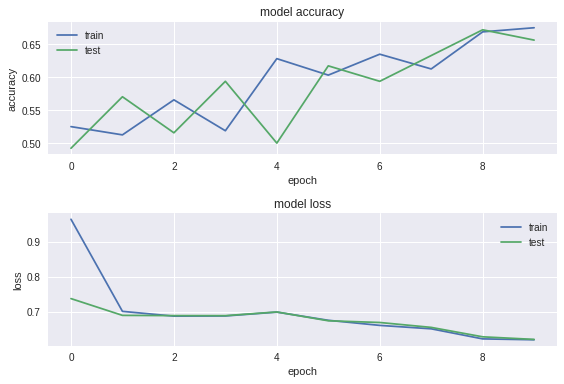

In [16]:
# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

# 5. Augmenting the dataset

Data augmentation gives ways to increase the size of the dataset. Data
augmentation introduces noise during training, producing robustness in the
model to various inputs.

There are various ways to augment the images. All these techniques are implemented in ImageDataGenerator to increase the dataset
size.

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/10
 - 4s - loss: 0.9951 - acc: 0.4875 - val_loss: 0.7021 - val_acc: 0.4688
Epoch 2/10
 - 3s - loss: 0.6817 - acc: 0.5469 - val_loss: 0.7754 - val_acc: 0.4844
Epoch 3/10
 - 3s - loss: 0.7088 - acc: 0.4938 - val_loss: 0.6965 - val_acc: 0.5234
Epoch 4/10
 - 3s - loss: 0.6957 - acc: 0.4938 - val_loss: 0.6914 - val_acc: 0.4922
Epoch 5/10
 - 3s - loss: 0.6817 - acc: 0.5563 - val_loss: 0.6806 - val_acc: 0.4688
Epoch 6/10
 - 3s - loss: 0.6860 - acc: 0.5687 - val_loss: 0.6860 - val_acc: 0.5938
Epoch 7/10
 - 3s - loss: 0.6876 - acc: 0.6005 - val_loss: 0.6710 - val_acc: 0.5859
Epoch 8/10
 - 3s - loss: 0.6880 - acc: 0.5812 - val_loss: 0.7201 - val_acc: 0.4922
Epoch 9/10
 - 3s - loss: 0.6672 - acc: 0.5656 - val_loss: 0.6416 - val_acc: 0.6172
Epoch 10/10
 - 3s - loss: 0.6597 - acc: 0.6437 - val_loss: 0.6673 - val_acc: 0.5703
Test-Accuracy: 52.97%

Maximum Loss : 0.9951
Minimum Loss : 0.6597
Loss difference : 0

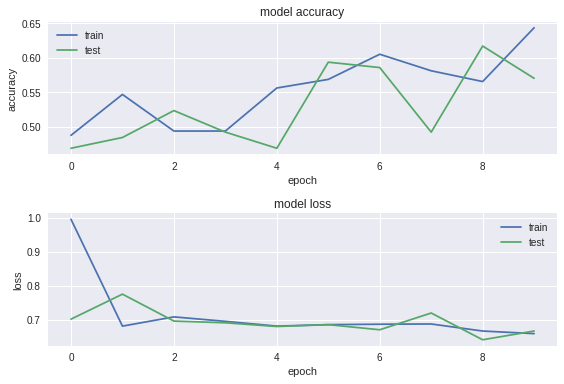

In [17]:
generator_train = ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  zoom_range=0.2,
  shear_range=0.2,
  rotation_range=45,
  width_shift_range=0.2,
  height_shift_range=0.2,
)
generator_test = ImageDataGenerator(rescale=1./255)

training_set = generator_train.flow_from_directory(train_dir,
   target_size = (image_height, image_width),
   batch_size = 32,
   class_mode = 'binary'
)
test_set = generator_test.flow_from_directory(test_dir,
   target_size =(image_height, image_width),
   batch_size = 32,
   class_mode = 'binary'
)

simple_cnn_model = create_model(input_shape)

results = simple_cnn_model.fit_generator(
      training_set,
      steps_per_epoch=epoch_steps,
      epochs=epochs,
      validation_data=test_set,
      validation_steps=test_steps,
      verbose = 2
)

print("Test-Accuracy:","%.2f%%\n" % (np.mean(results.history["val_acc"])*100))

# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

# 6. Transfer learning or fine-tuning of a model

# Training on bottleneck features

**VGG16 model**

![alt text](https://www.researchgate.net/profile/Kasthurirangan_Gopalakrishnan/publication/319952138/figure/fig2/AS:613973590282251@1523394119133/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained.png)

In [0]:
top_model_weights_path = 'bottleneck_fc_model.h5'  

### 6.1 Extract the bottleneck layers 

Extract the bottleneck layers as
follows:

In [19]:
model = keras.applications.VGG16(include_top=False)

generator = ImageDataGenerator(rescale=1. / 255)

train_images = generator.flow_from_directory(
  train_dir,
  batch_size=batch_size,
  target_size=(image_width, image_height),
  class_mode=None,
  shuffle=False
)
train_bottleneck_features = model.predict_generator(train_images, epoch_steps)
np.save('train_bottleneck_features.npy', train_bottleneck_features)  

test_images = generator.flow_from_directory(
  test_dir,
  batch_size=batch_size,
  target_size=(image_width, image_height),
  class_mode=None,
  shuffle=False
)
test_bottleneck_features = model.predict_generator(test_images, test_steps)
np.save('test_bottleneck_features.npy', test_bottleneck_features)

58892288/58889256 [==============================] - 3s 0us/step
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 6.2 Assign the labels

The VGG model is taken and used to predict the images. The labels are assigned
as follows:


In [0]:
train_labels = np.array([0] * int(no_train / 2) + [1] * int(no_train / 2))
test_labels = np.array([0] * int(no_test / 2) + [1] * int(no_test / 2))

### 6.3 Buidl a Sequential model

A sequential model with a couple of layers is built, compiled, and trained with
the bottleneck features and can be implemented using the code given as follows:

In [0]:
model = Sequential()
model.add(Flatten(input_shape=train_bottleneck_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### 6.4 Train the model

In [23]:
results = model.fit(
  train_bottleneck_features,
  train_labels,
  batch_size=batch_size,
  epochs=20,
  validation_data=(test_bottleneck_features, test_labels)
)

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 1s 533us/step - loss: 2.0341 - acc: 0.6240 - val_loss: 0.6340 - val_acc: 0.7300
Epoch 2/20
2000/2000 [==============================] - 0s 110us/step - loss: 0.5512 - acc: 0.7785 - val_loss: 0.2988 - val_acc: 0.8762
Epoch 3/20
2000/2000 [==============================] - 0s 110us/step - loss: 0.3046 - acc: 0.8675 - val_loss: 0.3165 - val_acc: 0.8625
Epoch 4/20
2000/2000 [==============================] - 0s 109us/step - loss: 0.2493 - acc: 0.8975 - val_loss: 0.2930 - val_acc: 0.8700
Epoch 5/20
2000/2000 [==============================] - 0s 108us/step - loss: 0.1952 - acc: 0.9255 - val_loss: 0.2395 - val_acc: 0.9038
Epoch 6/20
2000/2000 [==============================] - 0s 106us/step - loss: 0.1644 - acc: 0.9395 - val_loss: 0.2348 - val_acc: 0.9038
Epoch 7/20
2000/2000 [==============================] - 0s 107us/step - loss: 0.1484 - acc: 0.9440 - val_loss: 0.2320 - val_acc: 0.9050
E

### 6.5 Save weights: 

In [0]:
 model.save_weights(top_model_weights_path)  

### 6.6 Accuracy

Test-Accuracy :

In [25]:
print("Test-Accuracy:","%.2f%%\n" % (np.mean(results.history["val_acc"])*100))

Test-Accuracy: 89.40%



### 6.7 Evaluate the model to see the accuracy

Maximum Loss : 2.0341
Minimum Loss : 0.0245
Loss difference : 2.0095


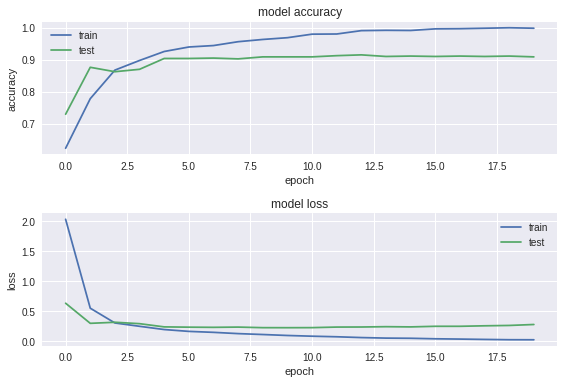

In [26]:
# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='down right')
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1025      
Total params: 8,390,657
Trainable params: 8,390,657
Non-trainable params: 0
_________________________________________________________________


### 6.8 Class Predictions

In [0]:
predictions = model.predict_classes(test_bottleneck_features)
predictions = predictions.reshape((predictions.shape[0]))
filenames=test_images.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)

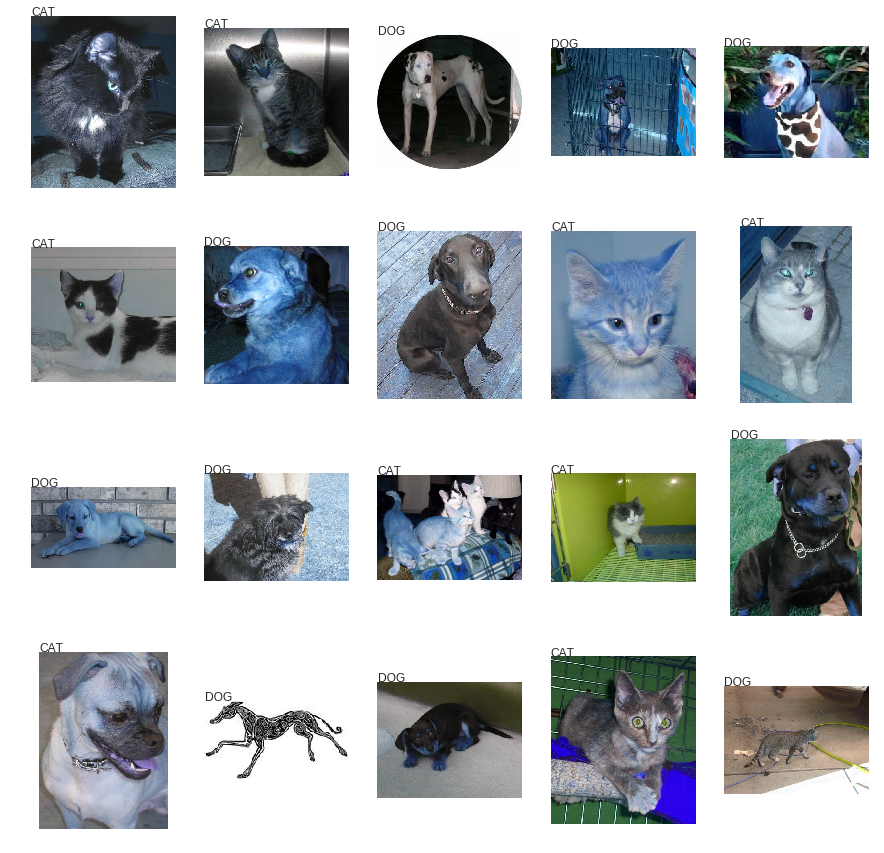

In [137]:
i = 0
plt.figure(figsize=(15,15))
sample = results.sample(20)

for index, row in sample.iterrows():
  image_path = "/content/dataset/copy_test/" + row["Filename"]
  orig  = cv2.imread(image_path)
 
  plt.subplot(4,5,i+1)
  plt.imshow(orig)
  if row["Predictions"] == 0:
    plt.text(0, 0,'CAT')
  else:
    plt.text(0, 0,'DOG')
  plt.grid('off')
  plt.axis('off')
  i += 1 

# 7. Test our model

### 7.1 Import files

In google colab we can import files through the following commands:

In [0]:
from google.colab import files
files.upload()

### 7.2 Define a function

Now we can define a function for testing our model

In [0]:
def test_model(image_path):
  orig  = cv2.imread(image_path)  
  orig  = cv2.resize(orig,(150,150))
  orig  = np.expand_dims(orig, axis=0)
  model_vgg16 = keras.applications.VGG16(include_top=False)
  bottleneck_prediction = model_vgg16.predict(orig)
  model_vgg16 = Sequential()
  model_vgg16.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
  model_vgg16.add(Dense(1024, activation='relu'))
  model_vgg16.add(Dropout(0.3))
  model_vgg16.add(Dense(1, activation='sigmoid'))
  model_vgg16.load_weights(top_model_weights_path)
  class_predicted = model_vgg16.predict_classes(bottleneck_prediction)

  plt.imshow(orig.reshape(150,150,3))
  plt.grid('off')
  plt.axis('off')
  if class_predicted[0,0] == 0:
    print('Predicted: cat')
  else:
    print('Predicted: dog')

### 7.3 Test out model on imported images:

Predicted: dog


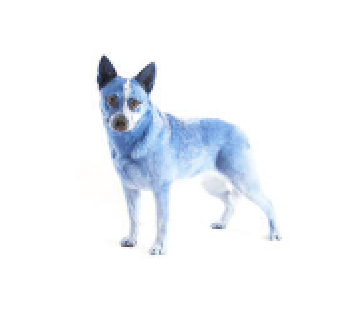

In [147]:
image_path = "/content/dog_test.jpg"
test_model(image_path)

Predicted: cat


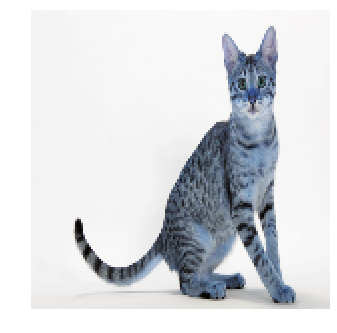

In [149]:
image_path = "/content/cat_test.jpg"
test_model(image_path)